# Anomaly detection in time series

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [11]:
plt.rcParams["figure.figsize"] = (9,5)

## Read the data

In [12]:
df = pd.read_csv('ec2_cpu_utilization_24ae8d.csv')
df.head()

,timestamp,value
0,2014-02-14 14:30:00,0.132
1,2014-02-14 14:35:00,0.134
2,2014-02-14 14:40:00,0.134
3,2014-02-14 14:45:00,0.134
4,2014-02-14 14:50:00,0.134


In [13]:
anomalies_timestamp = [
        "2014-02-26 22:05:00",
        "2014-02-27 17:15:00"
    ]

In [14]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

df.head()

,timestamp,value
0,2014-02-14 14:30:00,0.132
1,2014-02-14 14:35:00,0.134
2,2014-02-14 14:40:00,0.134
3,2014-02-14 14:45:00,0.134
4,2014-02-14 14:50:00,0.134


In [15]:
df['is_anomaly'] = 1

for each in anomalies_timestamp:
    df.loc[df['timestamp'] == each, 'is_anomaly'] = -1

df.head()

,timestamp,value,is_anomaly
0,2014-02-14 14:30:00,0.132,1
1,2014-02-14 14:35:00,0.134,1
2,2014-02-14 14:40:00,0.134,1
3,2014-02-14 14:45:00,0.134,1
4,2014-02-14 14:50:00,0.134,1


In [16]:
anomaly_df = df.loc[df['is_anomaly'] == -1]
inlier_df = df.loc[df['is_anomaly'] == 1]

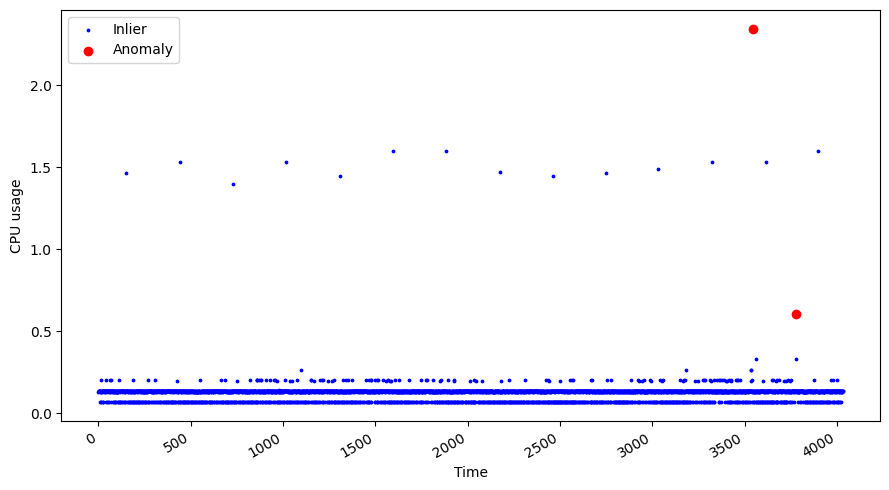

In [17]:
fig, ax = plt.subplots()

ax.scatter(inlier_df.index, inlier_df['value'], color='blue', s=3, label='Inlier')
ax.scatter(anomaly_df.index, anomaly_df['value'], color='red', label='Anomaly')
ax.set_xlabel('Time')
ax.set_ylabel('CPU usage')
ax.legend(loc=2)

plt.grid(False)
fig.autofmt_xdate()
plt.tight_layout()

## Baseline: median absolute deviation (MAD)

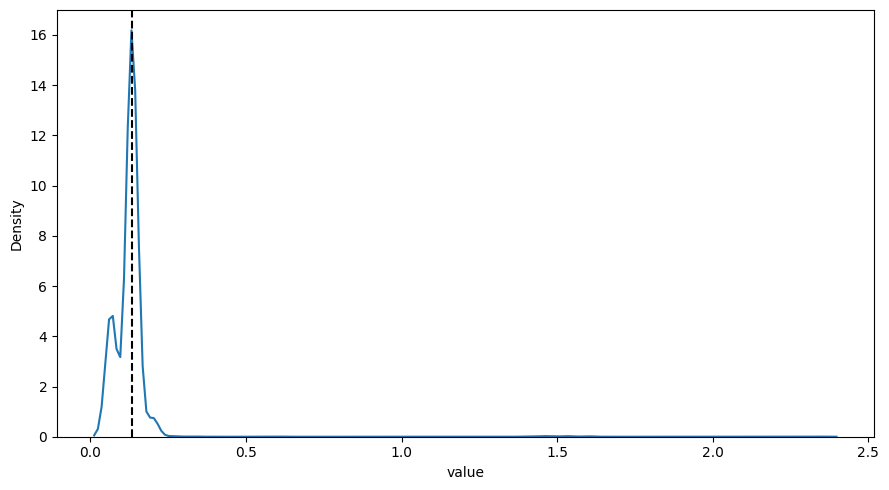

In [19]:
import seaborn as sns

sns.kdeplot(df['value']);
plt.grid(False)
plt.axvline(0.134, 0, 1, c='black', ls='--')
plt.tight_layout()

In [20]:
from scipy.stats import median_abs_deviation

mad = median_abs_deviation(df['value'])
median = np.median(df['value'])

print(median)
print(mad)

def compute_robust_z_score(x):
    return .6745*(x-median)/mad

0.134
0.0020000000000000018


In [21]:
df['z-score'] = df['value'].apply(compute_robust_z_score)

df.head()

,timestamp,value,is_anomaly,z-score
0,2014-02-14 14:30:00,0.132,1,-0.6745
1,2014-02-14 14:35:00,0.134,1,0.0000
2,2014-02-14 14:40:00,0.134,1,0.0000
3,2014-02-14 14:45:00,0.134,1,0.0000
4,2014-02-14 14:50:00,0.134,1,0.0000


In [22]:
df['baseline'] = 1

df.loc[df['z-score'] >= 3.5, 'baseline'] = -1
df.loc[df['z-score'] <=-3.5, 'baseline'] = -1

### Evaluation

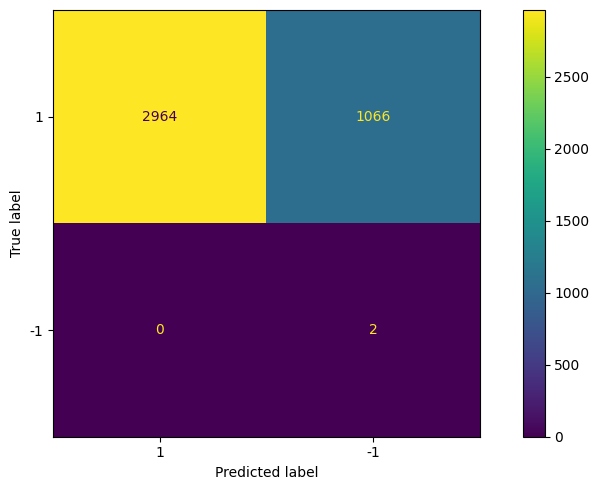

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(df['is_anomaly'], df['baseline'], labels=[1, -1])

disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])

disp_cm.plot();

plt.grid(False)
plt.tight_layout()